# Métodos Hierárquicos

In [2]:
# numpy for mathematics
import numpy as np

# pandas for data science
import pandas as pd

# matplotlib for plotting
from matplotlib import pyplot as plt

from auxiliary_func import *


## Processamento do Ficheiro

Lê-se o ficheiro de dados tratado, constrói-se o conjunto de variáveis categóricas e contínuas. Define-se o conjunto de variáveis explicativas e resposta.

In [3]:
from sklearn.impute import KNNImputer

df = pd.read_csv("MI.csv", header=None, index_col=0)
df = df.replace("?", np.nan)
df.drop(df.loc[:, 112:114], axis=1, inplace=True)
df.drop(df.loc[:, 116:123], axis=1, inplace=True)

Cols50pc = df.isna().sum().apply(lambda x: x > 850)
lessThan50pc = list(Cols50pc[Cols50pc == True].index)

# Delete colums with 30% of missing values
df.drop(df[lessThan50pc], axis=1, inplace=True)

continuous_ind = list(set([1, 34, 35, 36, 37, 83, 85, 86,
                      87, 88, 89, 90]) - set(lessThan50pc))  # Labels contínuas (obtidas do site)

categorical_ind = list(set(df.columns) - set(continuous_ind))

df_cont = pd.DataFrame()  # Data Frame contínuo
df_cat = pd.DataFrame()  # Data Frame categórico

cols = df.columns

imputer = KNNImputer(n_neighbors=1)
df = imputer.fit_transform(df)

df = pd.DataFrame(df, columns=cols)

j = 0  # Construction of data frames
for i in continuous_ind:
    df_cont.insert(j, i, df.loc[:, i])
    j = j + 1
j = 0
for i in categorical_ind:
    df_cat.insert(j, i, df.loc[:, i])
    j = j + 1


In [4]:


X = df.drop(115, axis=1)

X_cat = df_cat.drop(labels={115}, axis=1)

X_cont = df_cont

target = df[[115]]


## Análise

Grande parte são variáveis categóricas e binárias.

Novamente há várias coisas a testar:

- Retirar as contínuas
    - Investigar com One-Hot e Hamming 
    - Investigar com Gower
- Não retirar contínuas
    - Investigar com scaling e euclidiana
    - Investigar com Gower


### Funções auxiliares

In [169]:
from sklearn.metrics import rand_score, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import gower


def silhouette_score_list(X, affinity="euclidean", linkage="ward"):
    silhouette_scores = []

    n = [2, 3, 4, 5, 6, 7]

    for n_cluster in n:
        silhouette_scores.append(
            silhouette_score(X, AgglomerativeClustering(n_clusters=n_cluster, affinity = affinity, linkage = linkage).fit_predict(X)))

    plt.bar(n, silhouette_scores)
    plt.xlabel('Número Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

def pca_visualization2D(X, n_clusters, method=None, affinity = "euclidean", linkage = "ward"):
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    x = X_pca[:, 0]

    y = X_pca[:, 1]

    if method != None:
       X_pca = method(X_pca)

    
    plt.scatter(x, y,
                c=AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage).fit_predict(X_pca), cmap=plt.cm.autumn)

    plt.show()

def clustering_metrics(X, n_clusters, affinity = "euclidean", linkage = "ward"):

    clusters = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage).fit_predict(X)

    true_values = target.values.reshape(1, -1).tolist()[0]

    print("Random Index Score: " + str(rand_score(true_values, clusters)))
    print("Adjusted Random Index Score: " + str(adjusted_rand_score(true_values, clusters)))
    print("Adjusted Mutual Info Score: " + str(adjusted_mutual_info_score(true_values, clusters)))

    # O cluster contém apenas membros de uma dada classe
    print("Homogeneity: " + str(homogeneity_score(true_values, clusters)))
    # Todos os membros da classe pertencem ao mesmo cluster 
    print("Completeness: " + str(completeness_score(true_values, clusters)))

    cm = confusion_matrix(true_values, clusters)

    encode1 = LabelEncoder()

    encode2 = LabelEncoder()

    encode1.fit(["cluster 1", "cluster 2"])

    x = list(encode1.inverse_transform(clusters))

    encode2.fit(["No Ventricular Fibrillation", "Ventricular Fibrillation"])

    y = list(encode2.inverse_transform(list(map(int, true_values))))

    df = pd.DataFrame()

    df['Clusters'] = x
    df['Ventricular Fibrillation'] = y

    plot_met(cm)

    pd.crosstab(df.Clusters, df["Ventricular Fibrillation"]).plot(kind='bar', stacked=True)
    


### Clustering aglomerativo só com scaling normal e euclideana

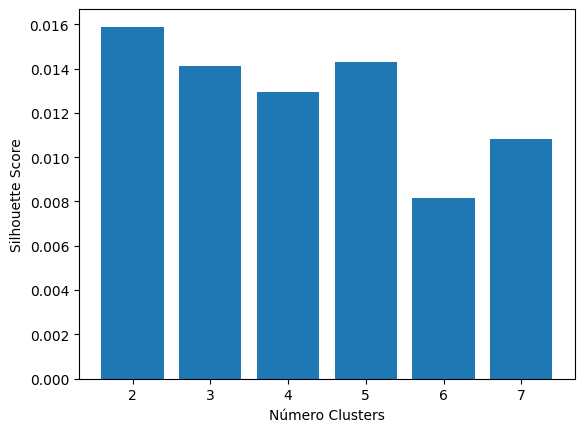

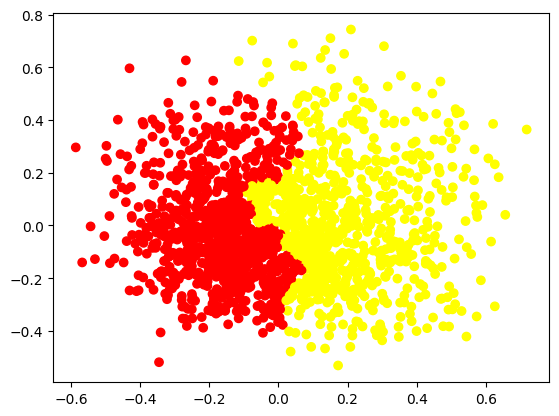

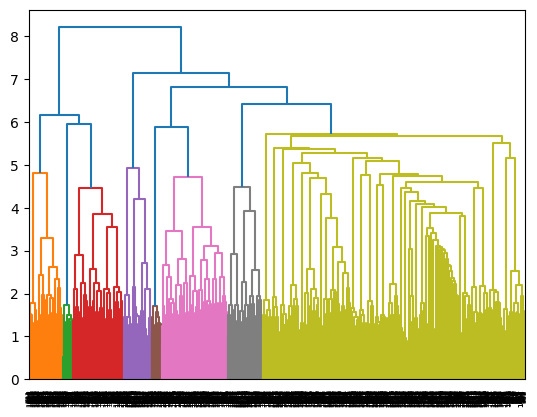

In [172]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import contingency_matrix
import scipy.cluster.hierarchy as shc

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

normalized_X = normalize(scaled_X)

silhouette_score_list(normalized_X)

pca_visualization2D(normalized_X, 2)

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(normalized_X)
                )

clustering_metrics(normalized_X, 2)


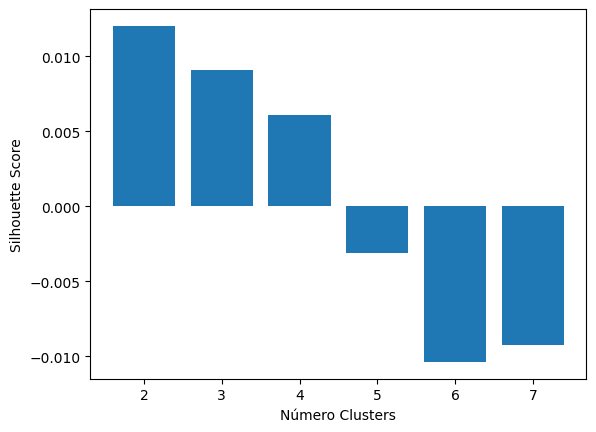

In [360]:
silhouette_score_list(normalized_X, linkage="complete")

pca_visualization2D(normalized_X, 2, linkage="complete")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="complete").fit(normalized_X)
                )

clustering_metrics(normalized_X, 2, linkage="complete")



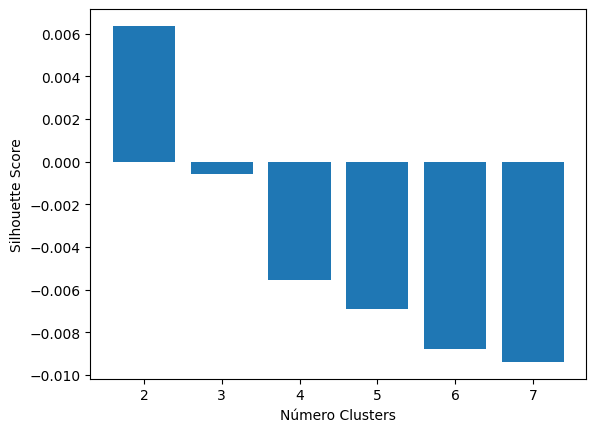

In [363]:
silhouette_score_list(normalized_X, linkage="single")

pca_visualization2D(normalized_X, 2, linkage="single")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="single").fit(normalized_X)
                )

clustering_metrics(normalized_X, 2, linkage="single")


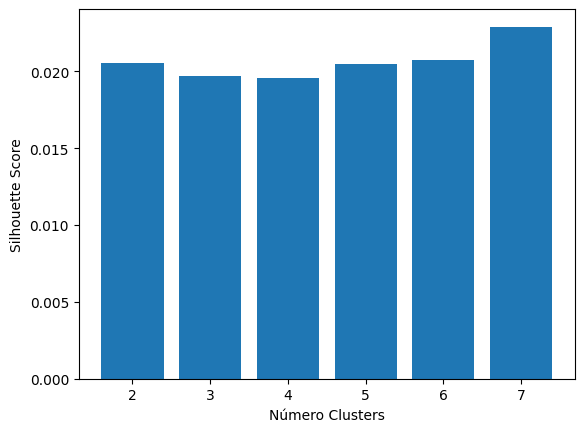

In [366]:
silhouette_score_list(normalized_X, linkage="average")

pca_visualization2D(normalized_X, 2, linkage="average")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="average").fit(normalized_X)
                )

clustering_metrics(normalized_X, 2, linkage="average")


### Clustering aglomerativo com Grower

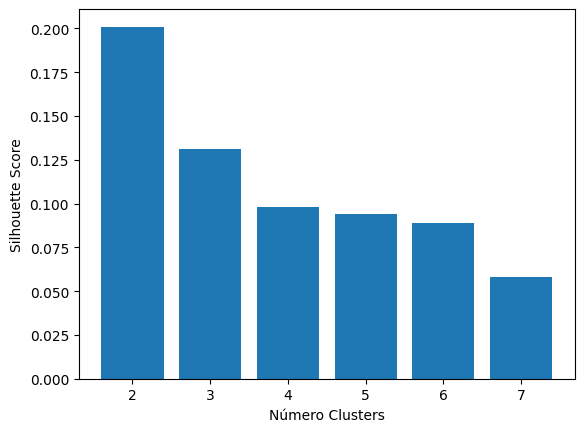

In [40]:
normalized_X_gower = gower.gower_matrix(normalized_X)

silhouette_score_list(normalized_X_gower, affinity="precomputed", linkage = "complete")

pca_visualization2D(normalized_X, 2, method=gower.gower_matrix,
                    affinity="precomputed", linkage="complete")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="precomputed", linkage="complete").fit(normalized_X_gower)
                )

clustering_metrics(normalized_X_gower, 2,
                   affinity="precomputed", linkage="complete")



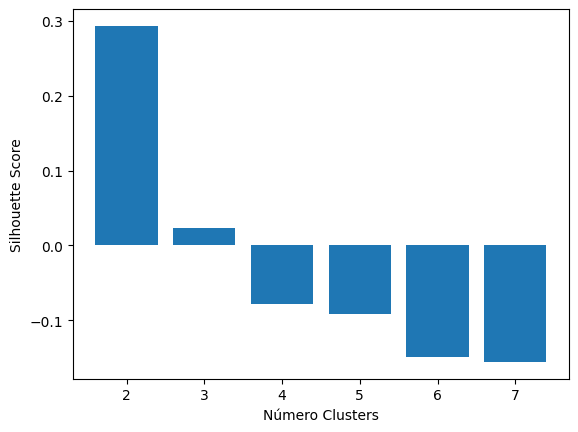

In [372]:

silhouette_score_list(normalized_X_gower,
                      affinity="precomputed", linkage="single")

pca_visualization2D(normalized_X, 2, method=gower.gower_matrix,
                    affinity="precomputed", linkage="single")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="precomputed", linkage="single").fit(normalized_X_gower)
                )

clustering_metrics(normalized_X_gower, 2,
                   affinity="precomputed", linkage="single")


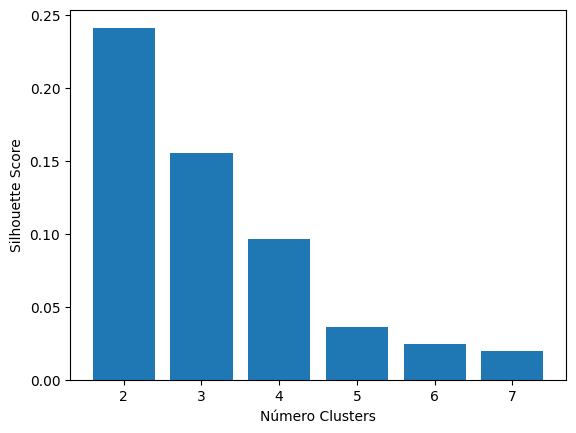

In [375]:

silhouette_score_list(normalized_X_gower,
                      affinity="precomputed", linkage="average")

pca_visualization2D(normalized_X, 2, method=gower.gower_matrix,
                    affinity="precomputed", linkage="average")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="precomputed", linkage="average").fit(normalized_X_gower)
                )

clustering_metrics(normalized_X_gower, 2,
                   affinity="precomputed", linkage="average")


### Clustering aglomerativo categóricas

Aqui consideramos duas métricas:

- Hamming
- Gower

In [45]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

X_cat_1H = encoder.fit_transform(X_cat)

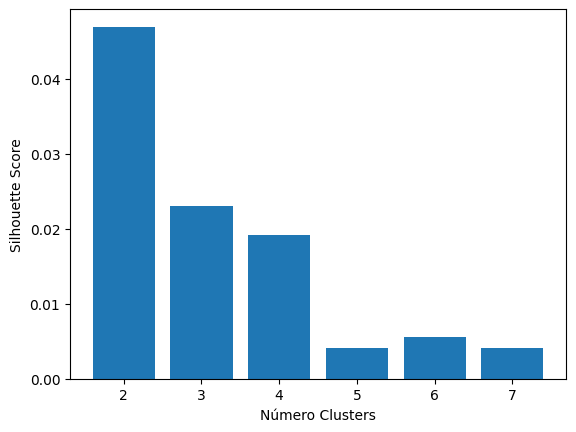

In [379]:
silhouette_score_list(X_cat_1H, affinity="hamming", linkage="complete")

pca_visualization2D(
    X_cat_1H, 2, affinity="hamming", linkage="complete")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="hamming", linkage="complete").fit(X_cat_1H)
                )

clustering_metrics(X_cat_1H, 2,
                   affinity="hamming", linkage="complete")


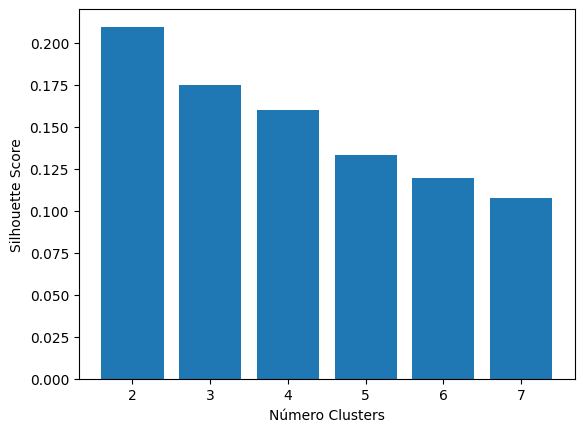

In [382]:
silhouette_score_list(X_cat_1H, affinity="hamming", linkage="single")

pca_visualization2D(
    X_cat_1H, 2, affinity="hamming", linkage="single")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="hamming", linkage="single").fit(X_cat_1H)
                )

clustering_metrics(X_cat_1H, 2,
                   affinity="hamming", linkage="single")


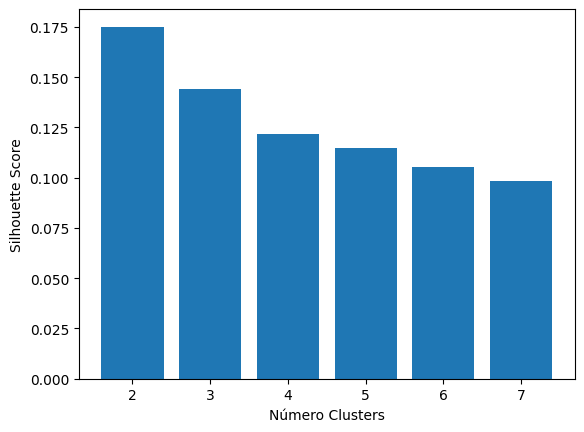

In [385]:
silhouette_score_list(X_cat_1H, affinity="hamming", linkage="average")

pca_visualization2D(
    X_cat_1H, 2, affinity="hamming", linkage="average")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="hamming", linkage="average").fit(X_cat_1H)
                )

clustering_metrics(X_cat_1H, 2,
                   affinity="hamming", linkage="average")


In [51]:
X_cat_gower = gower.gower_matrix(X_cat)

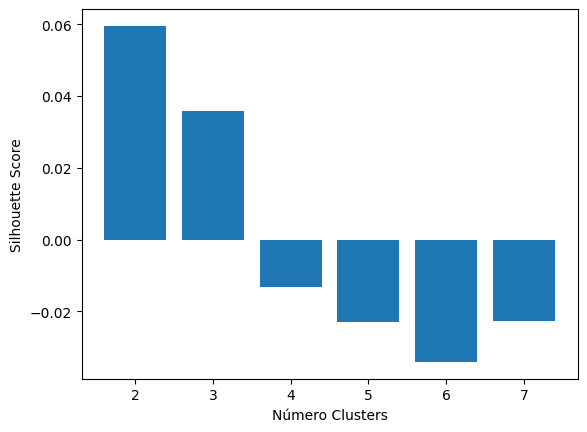

In [389]:
silhouette_score_list(X_cat_gower, affinity="precomputed", linkage="complete")

pca_visualization2D(X_cat, 2, method=gower.gower_matrix, affinity="precomputed", linkage="complete")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="precomputed", linkage="complete").fit(X_cat_gower)
                )

clustering_metrics(X_cat_gower, 2,
                   affinity="precomputed", linkage="complete")


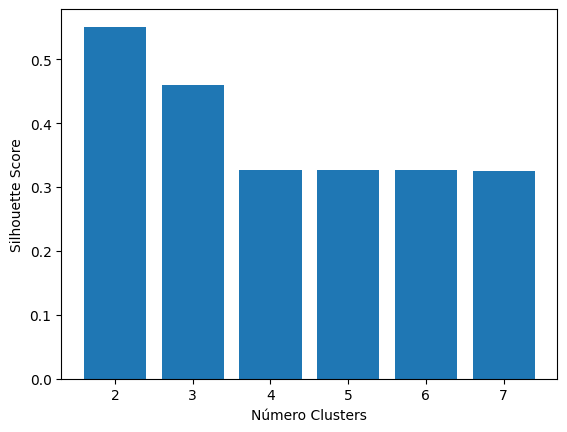

In [392]:
silhouette_score_list(X_cat_gower, affinity="precomputed", linkage="single")

pca_visualization2D(X_cat, 2, method=gower.gower_matrix,
                    affinity="precomputed", linkage="single")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="precomputed", linkage="single").fit(X_cat_gower)
                )

clustering_metrics(X_cat_gower, 2,
                   affinity="precomputed", linkage="single")


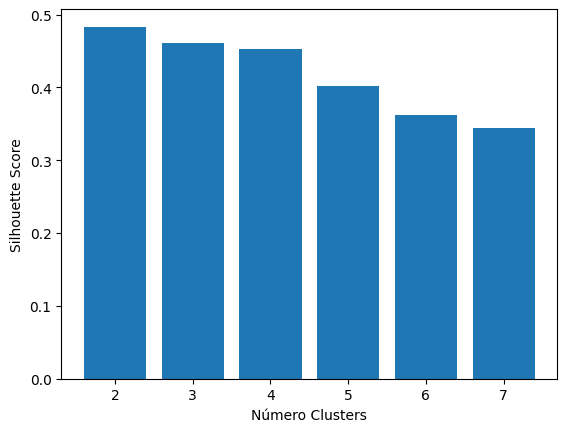

In [395]:
silhouette_score_list(X_cat_gower, affinity="precomputed", linkage="average")

pca_visualization2D(X_cat, 2, method=gower.gower_matrix,
                    affinity="precomputed", linkage="average")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="precomputed", linkage="average").fit(X_cat_gower)
                )

clustering_metrics(X_cat_gower, 2,
                   affinity="precomputed", linkage="average")
